## Plot main results

In [18]:
import lzma
import pickle
import matplotlib.pyplot as plt
import numpy as np
from multireward_ope.tabular.envs.make_env import make_env
from multireward_ope.tabular.reward_set import RewardSetRewardFree
import preamble_figures
import pandas as pd
import seaborn as sns
from multireward_ope.tabular.dataclasses import Config
from multireward_ope.tabular.agents.make_agent import make_agent
from multireward_ope.tabular.agents.dataclasses import AgentParameters
from scipy.stats import bootstrap

In [19]:
colors = {
    'SF-NR_': 'forestgreen',
    'GVFExplorer_':'black',#'#00bfc4',#'mediumorchid',#
    'MR-NaS-PE_500_False':'#f8766d',
    'Noisy-Policy_Uniform_0.3':'royalblue',
    'Noisy-Policy_Visitation based_0.3': 'firebrick',#'#3B3B3B',
}

In [26]:
envs =  [('Riverswim',15),('ForkedRiverswim',8),('DoubleChain',17),('NArms',15)]
envs =  [('Riverswim',20),('ForkedRiverswim',10),('DoubleChain',21),('NArms',20)]
envs =  [('Riverswim',30),('ForkedRiverswim',15),('DoubleChain',31),('NArms',30)]
HORIZON = 1000000

data = {}
for env, N in envs:
    results = []
    
    for agent in [
                'MR-NaS-PE_500_False',
                'SF-NR_',
                'GVFExplorer_',
                'Noisy-Policy_Uniform_0.3', 
                'Noisy-Policy_Visitation based_0.3']:

        filename = f'{HORIZON}_{env}_{N}_{agent}.lzma'
        print(f'Loading {filename}')
        with lzma.open(f'./data/tabular/Finite_MultiplePolicies/{filename}', 'rb') as f:
            res = pickle.load(f)
            results.append((agent, res))
        data[env] = results

   

Loading 1000000_Riverswim_30_MR-NaS-PE_500_False.lzma
Loading 1000000_Riverswim_30_SF-NR_.lzma
Loading 1000000_Riverswim_30_GVFExplorer_.lzma
Loading 1000000_Riverswim_30_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_Riverswim_30_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_ForkedRiverswim_15_MR-NaS-PE_500_False.lzma
Loading 1000000_ForkedRiverswim_15_SF-NR_.lzma
Loading 1000000_ForkedRiverswim_15_GVFExplorer_.lzma
Loading 1000000_ForkedRiverswim_15_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_ForkedRiverswim_15_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_DoubleChain_31_MR-NaS-PE_500_False.lzma
Loading 1000000_DoubleChain_31_SF-NR_.lzma
Loading 1000000_DoubleChain_31_GVFExplorer_.lzma
Loading 1000000_DoubleChain_31_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_DoubleChain_31_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_NArms_30_MR-NaS-PE_500_False.lzma
Loading 1000000_NArms_30_SF-NR_.lzma
Loading 1000000_NArms_30_GVFExplorer_.lzma
Loading 1000000_NArms_3

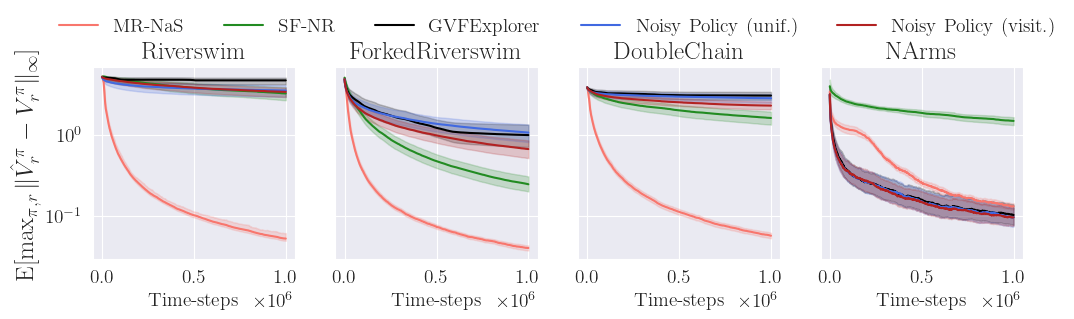

In [27]:
colors = {
    'SF-NR_': 'forestgreen',
    'GVFExplorer_':'black',#'#00bfc4',#'mediumorchid',#
    'MR-NaS-PE_500_False':'#f8766d',
    'Noisy-Policy_Uniform_0.3':'royalblue',
    'Noisy-Policy_Visitation based_0.3': 'firebrick',#'#3B3B3B',
}
fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,2.5))

name_map = {
    'SF-NR_': 'SF-NR',
    'GVFExplorer_': 'GVFExplorer',
    'MR-NaS-PE_500_False': 'MR-NaS',
    'Noisy-Policy_Uniform_0.3': 'Noisy Policy (unif.)' ,
    'Noisy-Policy_Visitation based_0.3': 'Noisy Policy (visit.)'
}

idx = 0
for env, N in envs:
    
    for agent_name, res in data[env]:
        err_rel = res['abs_results'] 
        errors = np.linalg.norm(err_rel, ord=np.inf, axis=-1).max(-1)
        xvalues = np.arange(errors.shape[1]) * 500
        res = bootstrap((errors,), np.mean, confidence_level=0.95)
        ax[idx].plot(xvalues, errors.mean(0), color=colors[agent_name], label=name_map[agent_name])
        ax[idx].fill_between(xvalues, res.confidence_interval.low, res.confidence_interval.high, color=colors[agent_name], alpha=0.2)

    ax[idx].set_yscale('log')
    ax[idx].set_title(env)
    ax[idx].set_xlabel('Time-steps')
    ax[idx].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    idx+=1
ax[0].set_ylabel(r'${\rm E}[\max_{\pi,r} \|\hat V_r^\pi - V_r^\pi\|_\infty]$',fontsize=18)
# ax[-1].legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

ax[0].legend(loc='upper center', bbox_to_anchor=(2.3, 1.3), borderaxespad=0, ncol=5, frameon=False)

plt.savefig(f"figures/{HORIZON}_multi_policy_multi_reward_abs_error_large.pdf", bbox_inches='tight')


In [16]:
envs =  [('Riverswim',15),('ForkedRiverswim',8),('DoubleChain',17),('NArms',15)]
# envs =  [('Riverswim',20),('ForkedRiverswim',10),('DoubleChain',21),('NArms',20)]
# envs =  [('Riverswim',30),('ForkedRiverswim',15),('DoubleChain',31),('NArms',30)]
HORIZON = 1000000

data2 = {}
for env, N in envs:
    results = []
    
    for agent in [
                'MR-NaS-PE_500_False',
                'SF-NR_',
                'Noisy-Policy_Uniform_0.3', 
                'Noisy-Policy_Visitation based_0.3']:

        filename = f'{HORIZON}_{env}_{N}_{agent}.lzma'
        print(f'Loading {filename}')
        with lzma.open(f'./data/tabular/RewardFree_MultiplePolicies/{filename}', 'rb') as f:
            res = pickle.load(f)
            results.append((agent, res))

        data2[env] = results

   

Loading 1000000_Riverswim_15_MR-NaS-PE_500_False.lzma
Loading 1000000_Riverswim_15_SF-NR_.lzma
Loading 1000000_Riverswim_15_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_Riverswim_15_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_ForkedRiverswim_8_MR-NaS-PE_500_False.lzma
Loading 1000000_ForkedRiverswim_8_SF-NR_.lzma
Loading 1000000_ForkedRiverswim_8_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_ForkedRiverswim_8_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_DoubleChain_17_MR-NaS-PE_500_False.lzma
Loading 1000000_DoubleChain_17_SF-NR_.lzma
Loading 1000000_DoubleChain_17_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_DoubleChain_17_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_NArms_15_MR-NaS-PE_500_False.lzma
Loading 1000000_NArms_15_SF-NR_.lzma
Loading 1000000_NArms_15_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_NArms_15_Noisy-Policy_Visitation based_0.3.lzma


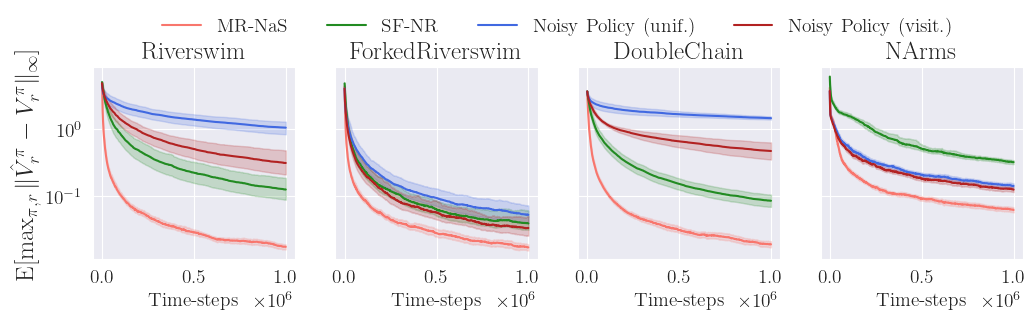

In [17]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,2.5))

name_map = {
    'SF-NR_': 'SF-NR',
    'GVFExplorer_': 'GVFExplorer',
    'MR-NaS-PE_500_False': 'MR-NaS',
    'Noisy-Policy_Uniform_0.3': 'Noisy Policy (unif.)' ,
    'Noisy-Policy_Visitation based_0.3': 'Noisy Policy (visit.)'
}
name_map = {
    'SF-NR_': 'SF-NR',
    'GVFExplorer_': 'GVFExplorer',
    'MR-NaS-PE_500_False': 'MR-NaS',
    'Noisy-Policy_Uniform_0.3': 'Noisy Policy (unif.)' ,
    'Noisy-Policy_Visitation based_0.3': 'Noisy Policy (visit.)'
}

idx = 0
for env, N in envs:
    
    # for agent_name, res in data2[env]:
    for agent_name, res in data2[env]:
        err_rel = res['abs_results'] 
        errors = np.linalg.norm(err_rel, ord=np.inf, axis=-1).max(-1)
        xvalues = np.arange(errors.shape[1]) * 500
        res = bootstrap((errors,), np.mean, confidence_level=0.95)
        ax[idx].plot(xvalues, errors.mean(0), color=colors[agent_name], label=name_map[agent_name])
        ax[idx].fill_between(xvalues, res.confidence_interval.low, res.confidence_interval.high, color=colors[agent_name], alpha=0.2)

    ax[idx].set_yscale('log')
    ax[idx].set_title(env)
    ax[idx].set_xlabel('Time-steps')
    ax[idx].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    idx+=1
ax[0].set_ylabel(r'${\rm E}[\max_{\pi,r} \|\hat V_r^\pi - V_r^\pi\|_\infty]$',fontsize=18)
# ax[-1].legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

ax[0].legend(loc='upper center', bbox_to_anchor=(2.3, 1.3), borderaxespad=0, ncol=5, frameon=False)

plt.savefig(f"figures/{HORIZON}_multi_policy_rewfree_abs_error_small.pdf", bbox_inches='tight')


In [31]:
envs =  [('Riverswim',15),('ForkedRiverswim',8),('DoubleChain',17),('NArms',15)]
envs =  [('Riverswim',20),('ForkedRiverswim',10),('DoubleChain',21),('NArms',20)]
envs =  [('Riverswim',30),('ForkedRiverswim',15),('DoubleChain',31),('NArms',30)]
HORIZON = 1000000

data3 = {}
for env, N in envs:
    results = []
    
    for agent in [
                'MR-NaS-PE_500_False',
                'Noisy-Policy_Uniform_0.3', 
                'Noisy-Policy_Visitation based_0.3']:

        filename = f'{HORIZON}_{env}_{N}_{agent}.lzma'
        print(f'Loading {filename}')
        with lzma.open(f'./data/tabular/RewardFree_SinglePolicy/{filename}', 'rb') as f:
            res = pickle.load(f)
            results.append((agent, res))

        data3[env] = results

   

Loading 1000000_Riverswim_30_MR-NaS-PE_500_False.lzma
Loading 1000000_Riverswim_30_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_Riverswim_30_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_ForkedRiverswim_15_MR-NaS-PE_500_False.lzma
Loading 1000000_ForkedRiverswim_15_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_ForkedRiverswim_15_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_DoubleChain_31_MR-NaS-PE_500_False.lzma
Loading 1000000_DoubleChain_31_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_DoubleChain_31_Noisy-Policy_Visitation based_0.3.lzma
Loading 1000000_NArms_30_MR-NaS-PE_500_False.lzma
Loading 1000000_NArms_30_Noisy-Policy_Uniform_0.3.lzma
Loading 1000000_NArms_30_Noisy-Policy_Visitation based_0.3.lzma


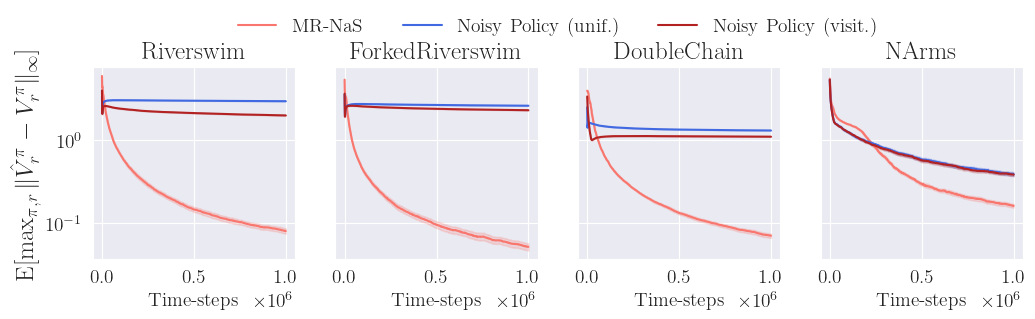

In [32]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,2.5))

name_map = {
    'SF-NR_': 'SF-NR',
    'GVFExplorer_': 'GVFExplorer',
    'MR-NaS-PE_500_False': 'MR-NaS',
    'Noisy-Policy_Uniform_0.3': 'Noisy Policy (unif.)' ,
    'Noisy-Policy_Visitation based_0.3': 'Noisy Policy (visit.)'
}
name_map = {
    'SF-NR_': 'SF-NR',
    'GVFExplorer_': 'GVFExplorer',
    'MR-NaS-PE_500_False': 'MR-NaS',
    'Noisy-Policy_Uniform_0.3': 'Noisy Policy (unif.)' ,
    'Noisy-Policy_Visitation based_0.3': 'Noisy Policy (visit.)'
}

idx = 0
for env, N in envs:
    
    for agent_name, res in data3[env]:
        err_rel = res['abs_results'] 
        errors = np.linalg.norm(err_rel, ord=np.inf, axis=-1).max(-1)
        xvalues = np.arange(errors.shape[1]) * 500
        res = bootstrap((errors,), np.mean, confidence_level=0.95)
        ax[idx].plot(xvalues, errors.mean(0), color=colors[agent_name], label=name_map[agent_name])
        ax[idx].fill_between(xvalues, res.confidence_interval.low, res.confidence_interval.high, color=colors[agent_name], alpha=0.2)

    ax[idx].set_yscale('log')
    ax[idx].set_title(env)
    ax[idx].set_xlabel('Time-steps')
    ax[idx].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    idx+=1
ax[0].set_ylabel(r'${\rm E}[\max_{\pi,r} \|\hat V_r^\pi - V_r^\pi\|_\infty]$',fontsize=18)
# ax[-1].legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

ax[0].legend(loc='upper center', bbox_to_anchor=(2.3, 1.3), borderaxespad=0, ncol=5, frameon=False)

plt.savefig(f"figures/{HORIZON}_single_policy_rewfree_abs_error_large.pdf", bbox_inches='tight')
